In [1]:
%matplotlib inline

import os
import yaml

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import astropy.io.fits as pyfits
from astropy.io import fits
from astropy.table import Table

import grizli
import grizli.catalog
from grizli import utils

from scipy.optimize import curve_fit
import pandas as pd

import eazy

print(f'grizli version: {grizli.__version__}')
print(f'eazy-py version: {eazy.__version__}')

Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git
grizli version: 1.11.2
eazy-py version: 0.6.8


### Set field & path
`abell2744clu` = Abell 2744 GLASS + UNCOVER + DD-2756

`gds` = GOODS-South

In [2]:
field = 'abell2744clu-grizli-v7.0' 
url_path = 'https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7'

## Raw photometry

NB: All photometry given in `fnu` flux densities with units of `microJansky` (AB zeropoint = 23.9).

In [3]:
phot = utils.read_catalog(f'{url_path}/{field}_phot.fits')
print(type(phot))
phot.columns

<class 'grizli.utils.GTable'>


<TableColumns names=('id','thresh','npix','tnpix','xmin','xmax','ymin','ymax','x','y','x2_image','y2_image','xy_image','errx2','erry2','errxy','a_image','b_image','theta_image','cxx_image','cyy_image','cxy_image','cflux','flux','cpeak','peak','xcpeak','ycpeak','xpeak','ypeak','flag','x_image','y_image','number','ra','dec','x_world','y_world','flux_iso','fluxerr_iso','area_iso','mag_iso','kron_radius','kron_rcirc','flux_auto','fluxerr_auto','bkg_auto','flag_auto','area_auto','flux_radius_flag','flux_radius_20','flux_radius','flux_radius_90','tot_corr','mag_auto','magerr_auto','flux_aper_0','fluxerr_aper_0','flag_aper_0','bkg_aper_0','mask_aper_0','flux_aper_1','fluxerr_aper_1','flag_aper_1','bkg_aper_1','mask_aper_1','flux_aper_2','fluxerr_aper_2','flag_aper_2','bkg_aper_2','mask_aper_2','flux_aper_3','fluxerr_aper_3','flag_aper_3','bkg_aper_3','mask_aper_3','clearp-f356w_flux_aper_0','clearp-f356w_fluxerr_aper_0','clearp-f356w_flag_aper_0','clearp-f356w_bkg_aper_0','clearp-f356w_mask_a

### Metadata

In [4]:
# General data of source detection
for i, k in enumerate(phot.meta):
    print(f'{k:>36} = {phot.meta[k]}')
    if i > 70:
        print('...')
        break

                             VERSION = 1.2.1
                             MINAREA = 9
                               CLEAN = True
                             DEBCONT = 0.001
                            DEBTHRSH = 32
                         FILTER_TYPE = conv
                           THRESHOLD = 1.5
                            KRONFACT = 2.5
                               KRON0 = 2.4
                               KRON1 = 3.8
                             MINKRON = 8.75000000000009
                            TOTCFILT = F140W
                            TOTCWAVE = 13922.907
                                  ZP = 28.9
                                PLAM = 13922.907
                                 FNU = 1e-08
                                FLAM = 1.4737148e-20
                              UJY2DN = 99.99395614709495
                            DRZ_FILE = abell2744clu-grizli-v7.0-ir_drc_sci.
                            WHT_FILE = abell2744clu-grizli-v7.0-ir_drc_wht.
                 

### Photometric apertures

In [5]:
for i, k in enumerate(phot.meta):
    if k.startswith('APER_'):
        aper_index = k[-1]
        print(f"Aperture index {aper_index}: *diameter* = {phot.meta[k]:4.1f} pixels = {phot.meta[k.replace('APER','ASEC')]:.2f} arcsec")

# Some observers use large apertures for their measurements to account for seeing, tracking, 
# and focus variations, while others use small apertures and apply aperture corrections (how do we choose here?)

Aperture index 0: *diameter* =  9.0 pixels = 0.36 arcsec
Aperture index 1: *diameter* = 12.5 pixels = 0.50 arcsec
Aperture index 2: *diameter* = 17.5 pixels = 0.70 arcsec
Aperture index 3: *diameter* = 25.0 pixels = 1.00 arcsec


In [6]:
# Columns for a particular filter + aperture
# bands in the HFF survey that cover the optical-IR: F435, F606, F814, F105, F140

aper_index = '2' 

cols = []

for k in phot.colnames:
    if k.startswith('f606w') & k.endswith(aper_index):
        cols.append(k)
        
phot[cols].info()

<GTable length=47888>
        name          dtype  unit    class     n_bad
-------------------- ------- ---- ------------ -----
   f606w_flux_aper_2 float64  uJy MaskedColumn  8008
f606w_fluxerr_aper_2 float64  uJy MaskedColumn  8008
   f606w_flag_aper_2   int16            Column     0
    f606w_bkg_aper_2 float64  uJy MaskedColumn  8008
   f606w_mask_aper_2 float64            Column     0


### Photometric bands

- NIRCam filters generally have "clear" in the filter name, which is the element in the `pupil` wheel.
- Filters that start with `clearp` are generally the long-wavelength NIRISS filters.
- Filters with names that end in `wn` are the NIRISS versions, e.g., `f200wn-clear` for NIRISS and `f200w-clear` for NIRCam
- HST filters ending in "u" are the WFC3/UVIS versions, e.g., `f814wu`

In [7]:
# bands 
count = 0
for k in phot.colnames:
    if k.endswith('_flux_aper_1'):
        count += 1
        print(f"{count:>2} {k.split('_flux')[0]}")

 1 clearp-f356w
 2 clearp-f444w
 3 f090w-clear
 4 f105w
 5 f115w-clear
 6 f115wn-clear
 7 f125w
 8 f140w
 9 f150w-clear
10 f150wn-clear
11 f160w
12 f200w-clear
13 f200wn-clear
14 f225wu
15 f275wu
16 f277w-clear
17 f336wu
18 f356w-clear
19 f410m-clear
20 f435w
21 f444w-clear
22 f475w
23 f606w
24 f775w
25 f814w


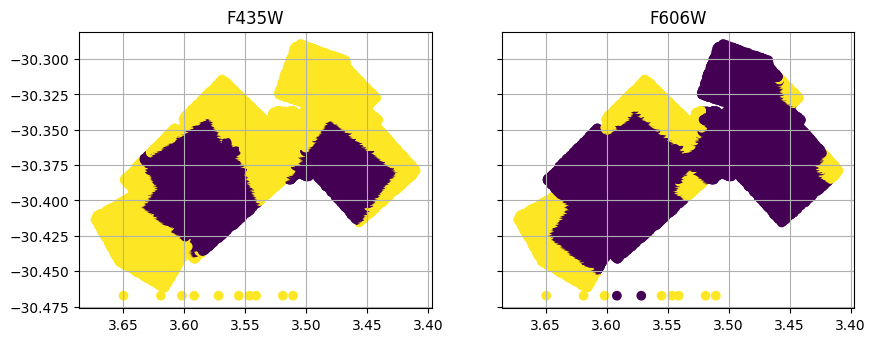

In [8]:
# Missing data are *masked* (?)

# bands in the HFF survey that cover the optical-IR: F435, F606, F814, F105, F140

fig, axes = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)

axes[0].scatter(phot['ra'], phot['dec'], c=phot['f435w_flux_aper_2'].mask)
axes[0].set_title('F435W') # what are (JADES/FRESCO)?
axes[1].scatter(phot['ra'], phot['dec'], c=phot['f606w_flux_aper_2'].mask)
axes[1].set_title('F606W')

axes[0].set_xlim(*axes[0].get_xlim()[::-1])
cosd = np.cos(np.nanmedian(phot['dec'])/180*np.pi)
for ax in axes:
    ax.set_aspect(1./cosd)
    ax.grid()

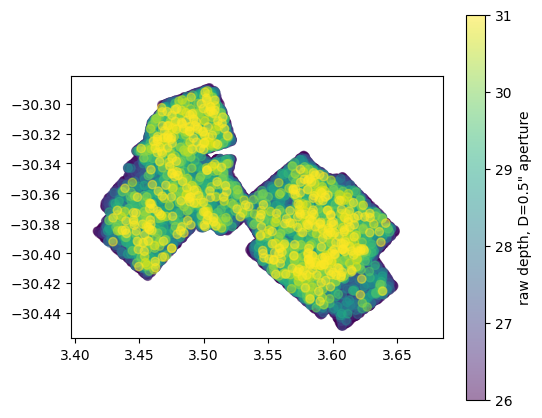

In [9]:
# 5-sigma depth in the D=0.5" aperture
depth = 23.9 - 2.5*np.log10(phot['f606w_flux_aper_2']*5) # how do you get 23.9?
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_aspect(1./cosd)
so = np.argsort(depth)
sc = ax.scatter(phot['ra'][so], phot['dec'][so], c=depth[so], vmin=26, vmax=31, alpha=0.5)
ax.set_xlim(*axes[0].get_xlim()[::-1])
cb = plt.colorbar(sc)
cb.set_label('raw depth, D=0.5" aperture')

### Point sources

Text(0, 0.5, 'flux_radius')

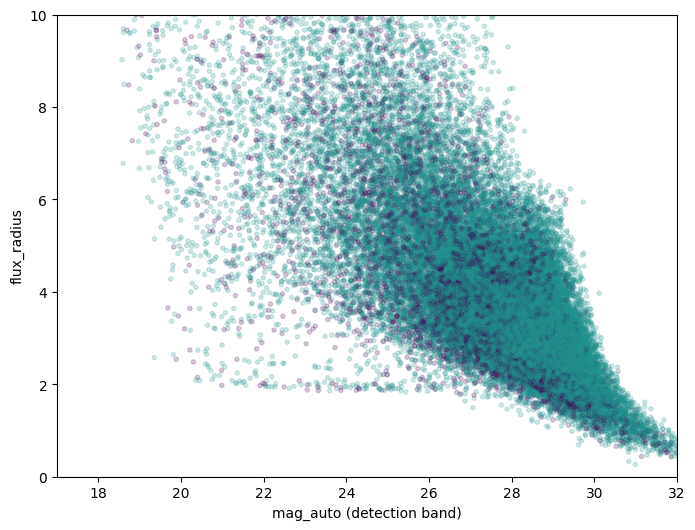

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))
in_jades = ~phot['f606w_flux_aper_2'].mask
ax.scatter(phot['mag_auto'], phot['flux_radius'], alpha=0.2, c=in_jades, vmin=0, vmax=2, cmap='viridis', marker='.')
ax.set_ylim(0,10); ax.set_xlim(17, 32)

ax.set_xlabel('mag_auto (detection band)'); ax.set_ylabel('flux_radius')


In [11]:
phot.columns

<TableColumns names=('id','thresh','npix','tnpix','xmin','xmax','ymin','ymax','x','y','x2_image','y2_image','xy_image','errx2','erry2','errxy','a_image','b_image','theta_image','cxx_image','cyy_image','cxy_image','cflux','flux','cpeak','peak','xcpeak','ycpeak','xpeak','ypeak','flag','x_image','y_image','number','ra','dec','x_world','y_world','flux_iso','fluxerr_iso','area_iso','mag_iso','kron_radius','kron_rcirc','flux_auto','fluxerr_auto','bkg_auto','flag_auto','area_auto','flux_radius_flag','flux_radius_20','flux_radius','flux_radius_90','tot_corr','mag_auto','magerr_auto','flux_aper_0','fluxerr_aper_0','flag_aper_0','bkg_aper_0','mask_aper_0','flux_aper_1','fluxerr_aper_1','flag_aper_1','bkg_aper_1','mask_aper_1','flux_aper_2','fluxerr_aper_2','flag_aper_2','bkg_aper_2','mask_aper_2','flux_aper_3','fluxerr_aper_3','flag_aper_3','bkg_aper_3','mask_aper_3','clearp-f356w_flux_aper_0','clearp-f356w_fluxerr_aper_0','clearp-f356w_flag_aper_0','clearp-f356w_bkg_aper_0','clearp-f356w_mask_a

## Some plots

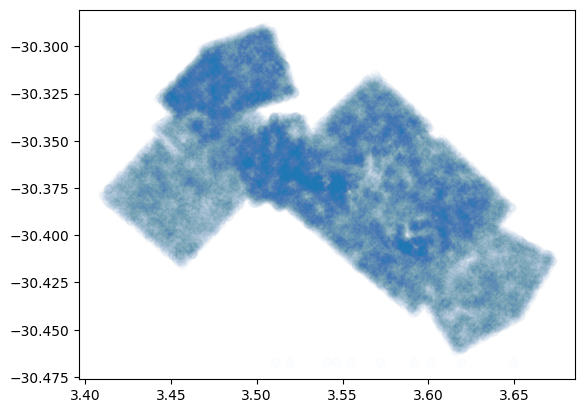

In [12]:
# RA vs Dec
plt.scatter(phot['ra'], phot['dec'], vmin=3.4, vmax=3.6, alpha=0.01)
# plt.scatter(phot['x_world'], phot['y_world'], vmin=3.4, vmax=3.6, alpha=0.01) # <-- celestial coordinates

In [13]:
# Flux vs major axis of image (what is the flux radius variable?) r enclosing 50% of flux?
#plt.scatter(phot['flux_radius'], phot['flux'], alpha=1, label='r', marker='.')
#plt.scatter(phot['flux_radius_20'], phot['flux'], alpha=1, label='r20', marker='.')
#plt.scatter(phot['flux_radius_90'], phot['flux'], alpha=1, label='r90', marker='.')
#plt.scatter(phot['a_image'], phot['flux'], alpha=1, label='major axis', marker='.')
#plt.legend()
#plt.xlim(-10, 250)

Kron claims that you capture most of the galaxy flux (>90%) if you use an aperture size twice the radius of the first image moment radius. (kron-like?)

In [14]:
# Magnitude (Kron-like aperture magnitude) vs Kron radius (radius of an aperture w specific fraction of flux)
# plt.scatter(phot['kron_radius'], phot['mag_auto'], alpha=0.1)

In [15]:
#plt.plot(phot['f435w_flux_aper_0'], label='F435')
#plt.plot(phot['f606w_flux_aper_0'], label='F606')
#plt.plot(phot['f814w_flux_aper_0'], label='F814')
#plt.plot(phot['f105w_flux_aper_0'], label='F105')
#plt.plot(phot['f140w_flux_aper_0'], label='F140')
#plt.legend()

# Photometric redshifts

In [16]:
import eazy.hdf5

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()

root = f'{field}-fix'

self = eazy.hdf5.initialize_from_hdf5(h5file=root+'.eazypy.h5')

zout = utils.read_catalog(root+'.eazypy.zout.fits')
self.cat = utils.read_catalog(root+'_phot_apcorr.fits')
cat = self.cat

Read default param file: /home/codespace/.python/current/lib/python3.10/site-packages/eazy/data/zphot.param.default
CATALOG_FILE is a table
   >>> NOBJ = 47888
f090w_tot_1 f090w_etot_1 (363): jwst_nircam_f090w
f105w_tot_1 f105w_etot_1 (202): hst/wfc3/IR/f105w.dat
f115w_tot_1 f115w_etot_1 (364): jwst_nircam_f115w
f115wn_tot_1 f115wn_etot_1 (309): niriss-f115w
f125w_tot_1 f125w_etot_1 (203): hst/wfc3/IR/f125w.dat
f140w_tot_1 f140w_etot_1 (204): hst/wfc3/IR/f140w.dat
f150w_tot_1 f150w_etot_1 (365): jwst_nircam_f150w
f150wn_tot_1 f150wn_etot_1 (310): niriss-f150w
f160w_tot_1 f160w_etot_1 (205): hst/wfc3/IR/f160w.dat
f200w_tot_1 f200w_etot_1 (366): jwst_nircam_f200w
f200wn_tot_1 f200wn_etot_1 (311): niriss-f200w
f277w_tot_1 f277w_etot_1 (375): jwst_nircam_f277w
f356w_tot_1 f356w_etot_1 (376): jwst_nircam_f356w
f410m_tot_1 f410m_etot_1 (383): jwst_nircam_f410m
f435w_tot_1 f435w_etot_1 (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
f444w_tot_1 f444w_etot_1 (377): jwst_nircam_f444w
f475w_tot_1 

TemplateGrid: user-provided tempfilt_data
Process templates: 0.504 s


294it [00:02, 105.95it/s]


h5: read corr_sfhz_13_bin0_av0.01.fits
h5: read corr_sfhz_13_bin0_av0.25.fits
h5: read corr_sfhz_13_bin0_av0.50.fits
h5: read corr_sfhz_13_bin0_av1.00.fits
h5: read corr_sfhz_13_bin1_av0.01.fits
h5: read corr_sfhz_13_bin1_av0.25.fits
h5: read corr_sfhz_13_bin1_av0.50.fits
h5: read corr_sfhz_13_bin1_av1.00.fits
h5: read corr_sfhz_13_bin2_av0.01.fits
h5: read corr_sfhz_13_bin2_av0.50.fits
h5: read corr_sfhz_13_bin2_av1.00.fits
h5: read corr_sfhz_13_bin3_av0.01.fits
h5: read corr_sfhz_13_bin3_av0.50.fits
h5: read fsps_4590.fits
h5: read j0647agn+torus.fits
fit_best: 17.5 s (n_proc=2,  NOBJ=46441)


In [17]:
#plt.scatter(zout['z_phot'], zout['z_spec'])

Text(0.5, 1.0, 'JWST abell2744clu-grizli-v7.0')

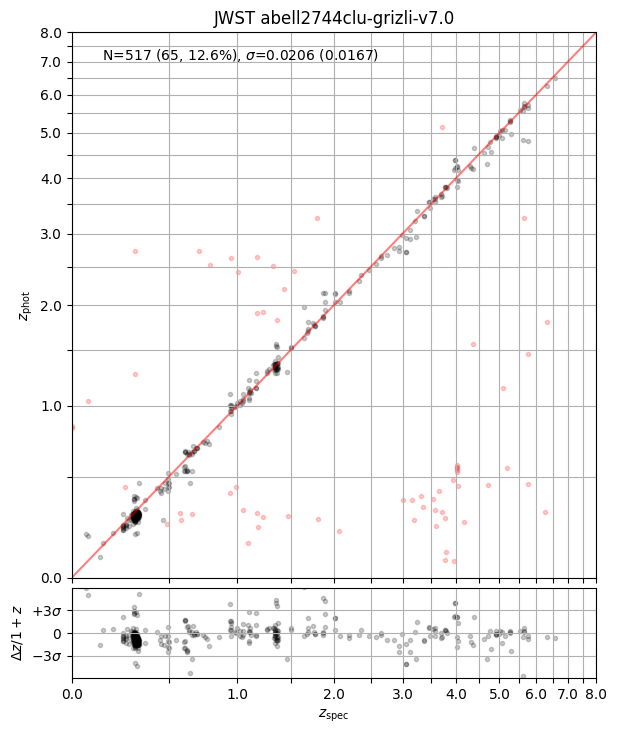

In [18]:
fig = eazy.utils.zphot_zspec(zout['z_phot'], zout['z_spec'], zmax=8)
fig.axes[0].set_title(f'JWST {field}')

In [87]:
#fig = eazy.utils.zphot_zspec(phot['mag_iso'], zout['z_phot'], zmax=8)
mag_f200 = 23.9 - 2.5*np.log10(phot['f200w-clear_flux_aper_2']) # apparent magnitude using zero point of 23.9
mag_f160 = 23.9 - 2.5*np.log10(phot['f160w_flux_aper_2']) 
mag_f814 = 23.9 - 2.5*np.log10(phot['f814w_flux_aper_2']) 

In [20]:
np.mean(zout['z_phot'])

2.602345

Text(0.5, 1.0, 'Photometric redshift distribution - Abell 2744')

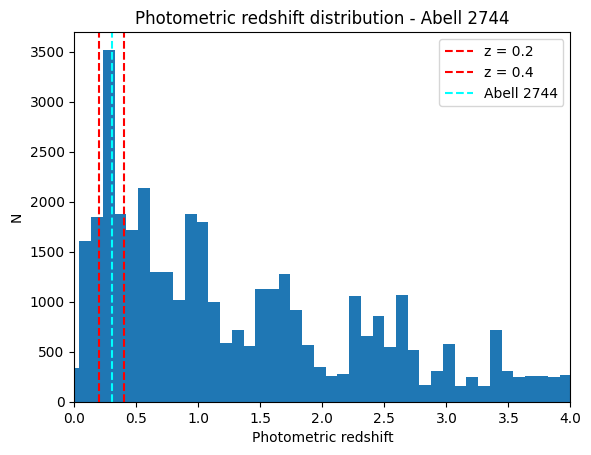

In [21]:
plt.hist(zout['z_phot'], bins=200)
plt.xlim(0, 4)
minl = 0.2
maxl = 0.4
plt.axvline(minl, linestyle='--', color='red', label='z = ' + str(minl))
plt.axvline(maxl, linestyle='--', color='red', label='z = ' + str(maxl))
plt.axvline(0.307, linestyle='--', color='cyan', label='Abell 2744')
plt.legend()
plt.xlabel('Photometric redshift'); plt.ylabel('N'); plt.title('Photometric redshift distribution - Abell 2744')
## mean at z ~ 2.6, most 1 < z < 2
## Likelihood that a particular galaxy is a cluster member -> galaxies < 0 and > 7.5 are foreground/background objects?

(0.0, 8.0)

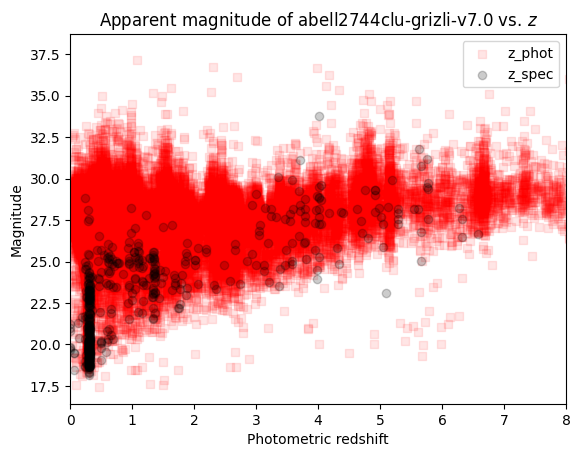

In [22]:
plt.scatter(zout['z_phot'], mag_f200, marker='s', alpha=0.1, label='z_phot', color='red')
plt.scatter(zout['z_spec'], mag_f200, marker='o', alpha=0.2, label='z_spec', color='black')
plt.legend(); plt.title(f'Apparent magnitude of {field} vs. $z$')
plt.ylabel('Magnitude'); plt.xlabel('Photometric redshift')

plt.xlim(0, 8) # based on histogram 

### min/max range to help select cluster members

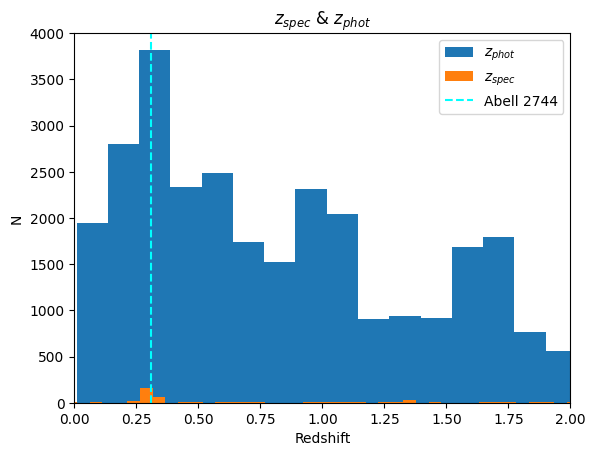

In [23]:
plt.hist(zout['z_phot'], bins=150, label='$z_{phot}$')
plt.hist(zout['z_spec'], bins=150, label='$z_{spec}$')
plt.axvline(0.307, linestyle='--', color='cyan', label='Abell 2744')
plt.xlim(0,2); plt.ylim(0, 4000)
plt.xlabel('Redshift'); plt.ylabel('N')
plt.title('$z_{spec}$ & $z_{phot}$')
plt.legend()

## Colour-colour diagrams

In [24]:
_rf = self.rest_frame_fluxes()

Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 REST_FRAME/maiz-apellaniz_Johnson_U.res 2006AJ....131.1184M lambda_c= 3.5900e+03 AB-Vega= 0.769 w95=862.3
   1 REST_FRAME/maiz-apellaniz_Johnson_B.res 2006AJ....131.1184M lambda_c= 4.3722e+03 AB-Vega=-0.106 w95=1321.3
   2 REST_FRAME/maiz-apellaniz_Johnson_V.res 2006AJ....131.1184M lambda_c= 5.4794e+03 AB-Vega= 0.002 w95=1369.1
   3 2MASS/J.res lambda_c= 1.2358e+04 AB-Vega= 0.885 w95=2311.1


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [07:32<00:00, 90.48s/it] 

 ... rest-frame flux: 452.5 s (n_proc=2,  NOBJ=46957)


In [25]:
"""
_rf = (,,) ->
ubvj_tempfilt = rf integrated template fluxes (total through a filter)
ubvj_lc = rf pivot wavelengths (effective wavelength based on filter's transmission properties)
ubvj = rf fluxes 
"""

_ubvj = _rf
UBVJ = [153,154,155,161] # default UBVJ filters
self.ubvj_tempfilt, self.ubvj_lc, self.ubvj = _ubvj
self.ubvj_f_numbers = UBVJ
        
restU = self.ubvj[:,0,2] # flux density
# restB = self.ubvj[:,1,2]
restV = self.ubvj[:,2,2]
restJ = self.ubvj[:,3,2]

UV = -2.5*np.log10(restU/restV) # rest-frame with AB magnitude
VJ = -2.5*np.log10(restV/restJ) 


Text(0.5, 1.0, 'UVJ diagram - master')

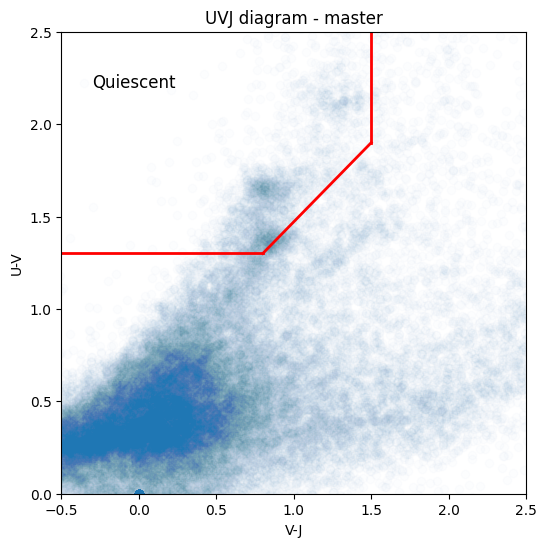

In [26]:
fig, ax = plt.subplots(figsize=(6, 6)) # top left part is quiescent

# lines based on Muzzin 2013
ax.plot([-0.5,0.8],[1.3,1.3],'r',lw=2) # left
ax.plot([0.8,1.5],[1.3,1.9],'r',lw=2) # diag
ax.plot([1.5,1.5],[1.9,2.5],'r',lw=2) # top

plt.scatter(VJ, UV, alpha=0.01)
plt.xlabel('V-J'); plt.ylabel('U-V')
plt.xlim(-0.5, 2.5); plt.ylim(0, 2.5)
ax.text(-0.3,2.2,'Quiescent',fontsize=12)
plt.title('UVJ diagram - master')

# dusty star-forming galaxies are red in V–J, quiescent galaxies are blue in V–J

In [27]:
# Creating a master dataframe of (z, U, V, J) in order to index by redshift
df = pd.DataFrame()

df['z_phot'] = list(zout['z_phot'])
df['U'] = list(restU)
df['V'] = list(restV)
df['J'] = list(restJ)

mag_f200_unmasked = np.where(mag_f200.mask, -1, mag_f200.data)
df['mag'] = mag_f200_unmasked 

df = df[df['mag'] > -1] # only valid ones now

df
#df.sort_values('z_phot')

,z_phot,U,V,J,mag
11,3.273083,0.026109,0.031926,0.012052,27.276341
12,1.369503,0.050390,0.050273,0.066888,27.041109
13,0.592300,0.384554,0.368641,0.534930,24.890549
14,0.943194,0.006753,0.010319,0.017364,28.083489
15,7.010970,0.025021,0.025458,0.013815,27.676515
...,...,...,...,...,...
47883,3.093199,0.028496,0.044418,0.253439,26.955164
47884,0.732545,0.039912,0.055187,0.076363,26.540868
47885,0.672800,0.351891,0.805946,6.283472,22.673785
47886,0.340983,0.028166,0.042522,0.059189,26.798350


In [28]:
def UVJ_diagram(df):
    """ For a given dataframe of shape (z, U, V, J, mag), 
        return the minimum and maximum z and UV and VJ bands
    """
    min_z = min(df['z_phot'])
    max_z = max(df['z_phot'])
    UV = -2.5*np.log10(df['U']/df['V'])
    VJ = -2.5*np.log10(df['V']/df['J'])
    
    return min_z, max_z, VJ, UV

In [29]:
# Creating dataframes for different ranges of redshift

z1 = df[(df['z_phot'] >= 0.05) & (df['z_phot'] <= 0.25)]
z2 = df[(df['z_phot'] > 0.25) & (df['z_phot'] <= 0.35)]
z3 = df[(df['z_phot'] > 0.35) & (df['z_phot'] <= 0.6)]
z4 = df[(df['z_phot'] > 0.6) & (df['z_phot'] <= 0.95)]
z5 = df[(df['z_phot'] > 0.95) & (df['z_phot'] <= 1.35)]
z6 = df[(df['z_phot'] > 1.35) & (df['z_phot'] <= 1.90)]

zs=[z1,z2,z3,z4 ,z5, z6]

c = 0
for z in zs:
    print(len(z))
    c += (len(z))

print(c / len(df) * 100, '%')

3439
3311
3535
3538
3776
3678
57.239319918218015 %


In [30]:
def plot_df_subsets(df_list, cut=''):
    # Subplots for each range of z/mag
    fig, axs = plt.subplots(3, 2, figsize=(8, 10), sharex=True, sharey=True)
    fig.suptitle('UVJ Diagram - Abell 2744' + ' (' + cut + ')')

    for i, variable in enumerate(zs):
        x = i//2; y = i%2 

        axs[x,y].scatter(UVJ_diagram(zs[i])[2], UVJ_diagram(zs[i])[3], alpha=0.075, marker='*') 
        axs[x,y].set_xlim(-0.5, 2.5); axs[x,y].set_ylim(0, 2.5)
        axs[x,y].text(-0.2, 2.2, str(round(UVJ_diagram(zs[i])[0], 2))+' $\leq$ z $\leq$ '+str(round(UVJ_diagram(zs[i])[1], 2)),fontsize=10)
        axs[x,y].set_xlabel('V-J')
        axs[x,y].set_ylabel('U-V')  

        axs[x,y].grid(alpha=0.7)

        axs[x,y].plot([-0.5,0.8],[1.3,1.3],'r',lw=2) # left
        axs[x,y].plot([0.81,1.5],[1.3,1.9],'r',lw=2) # diag
        axs[x,y].plot([1.5,1.5],[1.9,2.5],'r',lw=2) # top

    plt.tight_layout()
    plt.show()

    return 1

    # concentrated cluster galaxies & background galaxies deviating in colour?

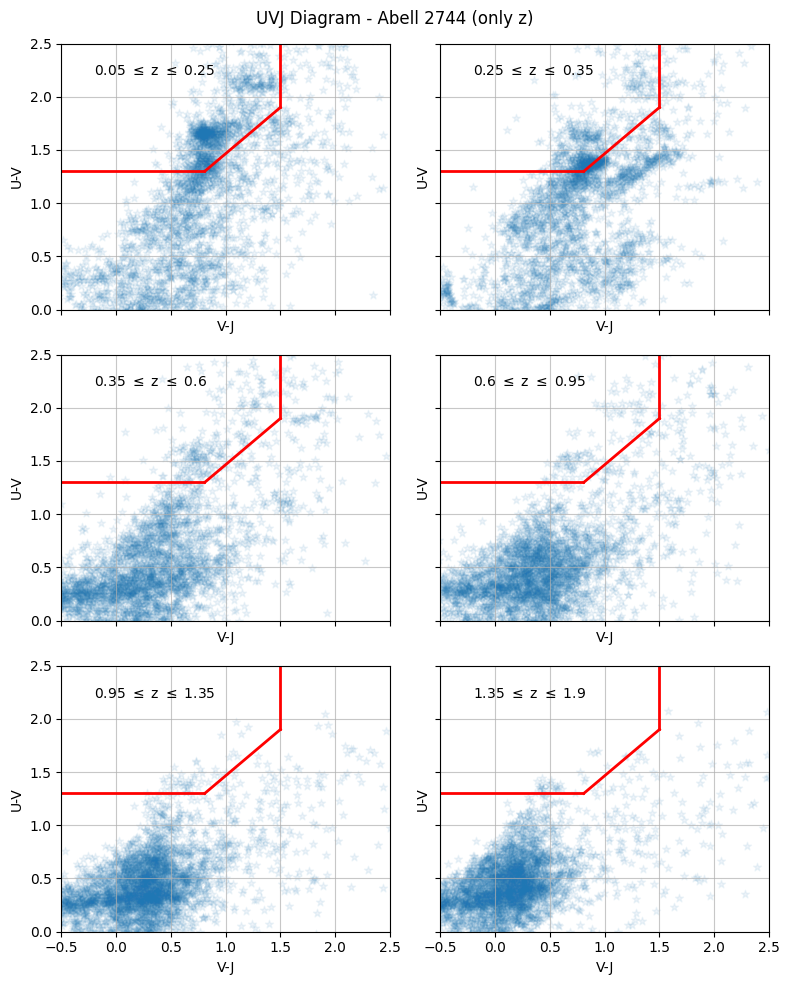

1

In [31]:
plot_df_subsets(zs, cut='only z')

## Magnitude

In [89]:
# reminder:
    # mag_f200_unmasked = np.where(mag_f200.mask, -1, mag_f200.data)
    # df['mag'] = mag_f200_unmasked 

mag_f160_unmasked = np.where(mag_f160.mask, -1, mag_f160.data)
mag_f814_unmasked = np.where(mag_f814.mask, -1, mag_f814.data)

(array([4.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00, 5.0000e+00,
        1.4000e+01, 2.0000e+01, 2.0000e+01, 2.4000e+01, 2.3000e+01,
        3.8000e+01, 2.9000e+01, 3.8000e+01, 4.0000e+01, 3.5000e+01,
        4.5000e+01, 5.2000e+01, 7.1000e+01, 5.8000e+01, 5.1000e+01,
        7.5000e+01, 7.5000e+01, 8.6000e+01, 9.7000e+01, 1.0900e+02,
        1.0500e+02, 1.2600e+02, 1.3200e+02, 1.6200e+02, 2.1500e+02,
        2.4400e+02, 1.0954e+04, 2.7300e+02, 3.2400e+02, 3.5800e+02,
        4.2300e+02, 4.6500e+02, 4.8700e+02, 5.2800e+02, 6.3400e+02,
        6.0200e+02, 7.0900e+02, 8.0800e+02, 8.7600e+02, 9.8100e+02,
        1.1600e+03, 1.2590e+03, 1.3260e+03, 1.5650e+03, 1.6870e+03,
        1.8710e+03, 1.9120e+03, 2.0900e+03, 2.0480e+03, 1.9500e+03,
        1.8150e+03, 1.6330e+03, 1.3680e+03, 1.1280e+03, 8.7800e+02,
        7.7800e+02, 6.0100e+02, 4.9800e+02, 3.3900e+02, 2.6900e+02,
        2.5300e+02, 1.9700e+02, 1.5700e+02, 1.0900e+02, 1.1100e+02,
        8.9000e+01, 7.7000e+01, 6.1000e+01, 5.00

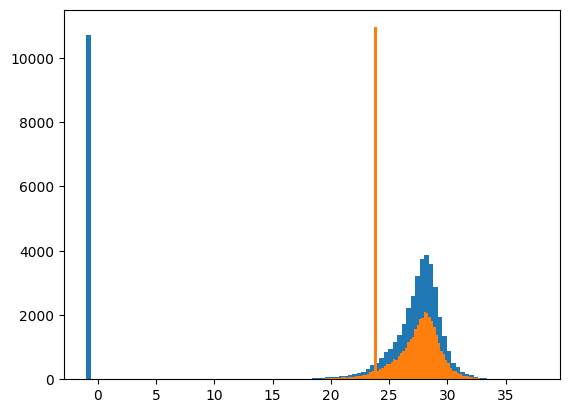

In [90]:
plt.hist(mag_f200_unmasked, bins=100, label='F200 unmasked?') # many of these at -1
plt.hist(mag_f200, bins=100, label='F200 masked?')

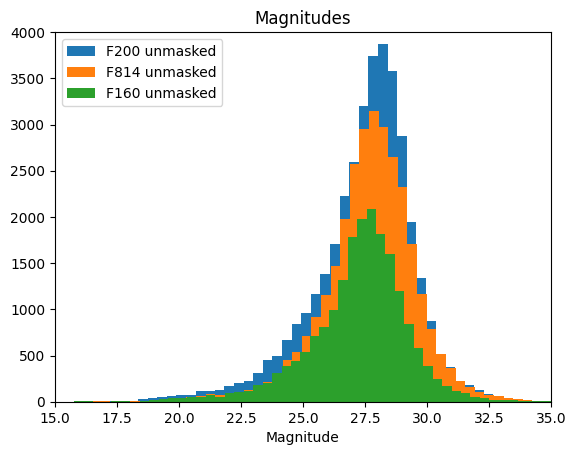

In [93]:
plt.hist(mag_f200_unmasked, bins=100, label='F200 unmasked')
plt.hist(mag_f814_unmasked, bins=100, label='F814 unmasked')
plt.hist(mag_f160_unmasked, bins=100, label='F160 unmasked')
plt.xlim(15, 35); plt.ylim(0, 4000)
plt.xlabel('Magnitude')
plt.title('Magnitudes')
plt.legend()


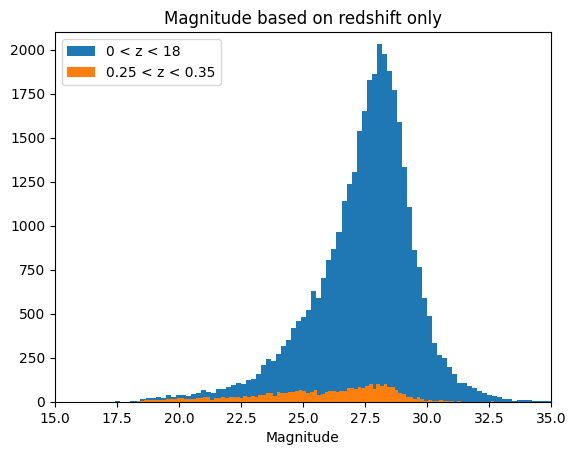

In [34]:
# NO MAGNITUDE BINS:

df_cut =  df[(df['z_phot'] > 0) & (df['z_phot'] <= 18)]
df_cut1 =  df[(df['z_phot'] > 0.25) & (df['z_phot'] <= 0.35)]
              
plt.hist(df_cut['mag'], bins=100, label='0 < z < 18')
plt.hist(df_cut1['mag'], bins=100, label='0.25 < z < 0.35')
plt.xlim(15,35), plt.ylim(0, 2100)
plt.xlabel('Magnitude')
plt.title('Magnitude based on redshift only')

plt.legend()

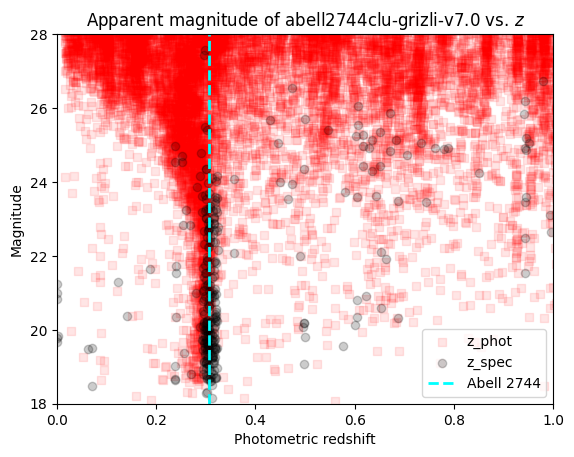

In [35]:
plt.scatter(zout['z_phot'], mag_f200, marker='s', alpha=0.1, label='z_phot', color='red')
plt.scatter(zout['z_spec'], mag_f200, marker='o', alpha=0.2, label='z_spec', color='black')
plt.title(f'Apparent magnitude of {field} vs. $z$')
plt.ylabel('Magnitude'); plt.xlabel('Photometric redshift')

plt.xlim(0, 1); plt.ylim(18, 28)
plt.axvline(0.307, color='cyan', linestyle='--', linewidth=2, label='Abell 2744')
plt.legend()

### Binning for magnitude - UVJ Diagrams

In [67]:
# Creating dataframes for different ranges of magnitude (on top of redshift)
ms = []

for z in zs:
    m_cut = z[(z['mag'] >= 18) & (z['mag'] <= 24)]
    ms.append(m_cut)

for m in ms:
    print(len(m))

96
842
180
265
285
274


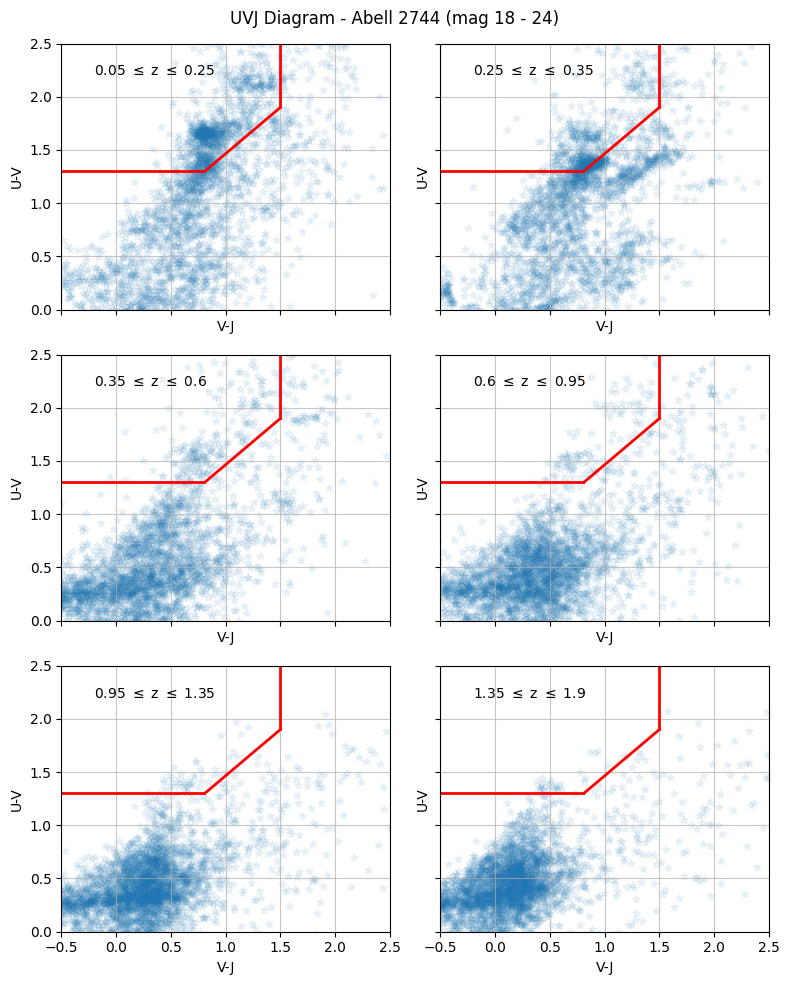

1

In [68]:
plot_df_subsets(ms, cut='mag 18 - 24')

## Luminosity Function

0 3
1 4
2 18
3 26
4 32
5 43
6 66
7 76
8 83
9 87
10 94
11 99
12 100
13 129
14 133
15 168
16 178
17 185
18 214
19 223
20 225
21 228
22 229
23 242
24 247
25 249
26 254
27 263
28 264
29 284
30 297
31 299
32 315
33 349
34 368
35 374
36 378
37 391
38 392
39 393
40 434
41 443
42 445
43 467
44 482
45 488
46 507
47 516
48 543
49 544
50 547
51 561
52 566
53 576
54 583
55 585
56 634
57 638
58 647
59 654
60 656
61 657
62 658
63 660
64 663
65 676
66 682
67 684
68 687
69 702
70 717
71 729
72 735
73 736
74 747
75 751
76 752
77 754
78 778
79 781
80 782
81 787
82 808
83 809
84 816
85 817
86 828
87 831
88 850
89 867
90 870
91 887
92 900
93 905
94 910
95 916
96 919
97 921
98 932
99 939
100 943
101 963
102 968
103 981
104 989
105 993
106 1003
107 1019
108 1023
109 1054
110 1102
111 1108
112 1113
113 1135
114 1144
115 1162
116 1164
117 1174
118 1176
119 1177
120 1179
121 1182
122 1186
123 1195
124 1202
125 1206
126 1207
127 1208
128 1229
129 1231
130 1233
131 1260
132 1264
133 1293
134 1302
135 1322
136 13

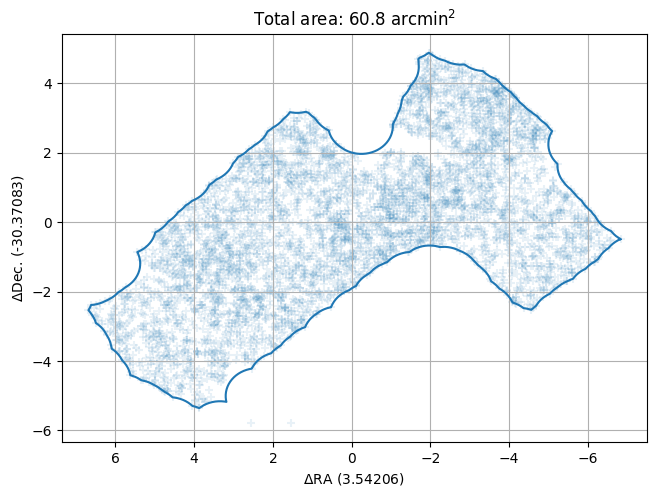

In [55]:
area, area_fig = grizli.utils.catalog_area(phot['ra'], phot['dec']) # square arcminutes

In [140]:
# Schechter function:
def schechter(mag, M_star=-21.9,a=-1.19,phi_star=11):
    func = 0.4*np.log(10) * phi_star * 10**(-0.4*(mag-M_star)*(a+1)) * np.exp(-10**(-0.4*(mag-M_star)))
    return func

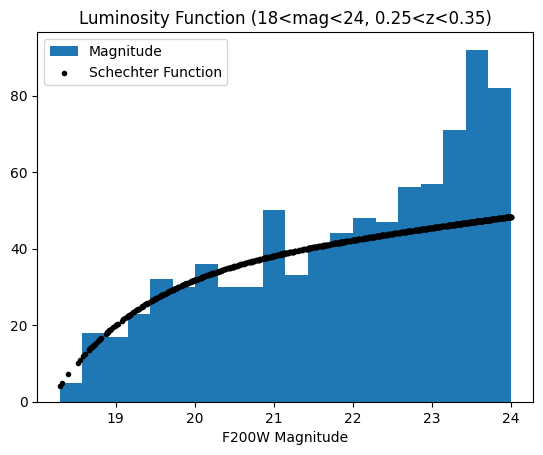

In [143]:
sch = schechter(ms[1]['mag'], M_star=19,a=-1.19,phi_star=11)

plt.title('Luminosity Function (18<mag<24, 0.25<z<0.35)')
plt.hist(ms[1]['mag'], bins=20, label='Magnitude')
plt.scatter(ms[1]['mag'], np.log10(sch)*35, label='Schechter Function', color='k', marker='.')
plt.xlabel('F200W Magnitude')
plt.legend()

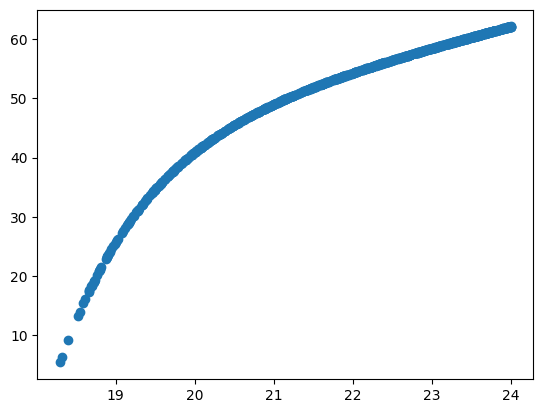

In [123]:
plt.scatter(ms[1]['mag'], np.log10(sch)*45)